# Cancer Drug Response Modeling

### Description :

Drug response for each drug is modeled and evaluated using data from 310 cell-line mutations provided by the GDSC website using five separate modeling techniques. 

These modeling techniques include: Elastic nets, Ridge regression, least absolute shrinkage and selection operator, random forest, and SVM with linear kernels

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Importation 

### Loading Data Set 1: GDSC 

Please note that before running the code, you will need all the GDSC files. They can be found on the drive (https://drive.google.com/drive/u/1/folders/11omvpOttkdZZgv_ppbtcCbojkuVR-D61) or directly on the GDSC website.

In [2]:
NB_DRUGS = 10 #number of best drugs to select
SCORE = "LN_IC50" #how the sensitivity of the drug is computed; other option: "AUC" 
SAVE = True #whether to save the final matrix or not

#### Cell populations and labels


File which represents how well each cell population reacted to each drug.



1. How is the drug measured?

      a. IC50: describes the concentration of an inhibitor that results in a half-maximal inhibition of a response (i.e. the concentration that reduces a response to 50% of its maximum). That maximum response being inhibited is due to the action of something else (typically an agonist for the receptor of interest). Maximum IC50 = 8. Minimum IC50 = 0.

      IC50 is obtained by plotting a measure of the cell death rate vs the concentration of the drug. IC50 is expressed as a concentration so the higher the concentration of drug needed to kill the cell line the more resistant that cell line is. If the IC50 is very low then the concentration (or amount) of drug needed to kill the cell line is also very low which means the cell line is more sensitive. Typically you get a S curve or sigmoidal curve. IC50 is the middle point of the sigmoidal curve. The threshold for calling a drug sensitive/resistant changes depending upon the IC50 value and we need to see how the sigmoidal curve behaves.

      d. ActArea: "Sensitivity was assayed by measuring cellular ATP levels as a surrogate for cell number and growth. Raw data were merged with assay metadata, and percent-viability scores were calculated relative to DMSO controls, after which concentration-response curves were fit for percent viability. The areas under percent-viability curves were computed and used as the measure of sensitivity". In one paper, the limit was set to 0.8 SD. Sensitive cell lines were the ones with an activity area at least 0.8 SD above the mean. Resistant cell lines had an activity area at least 0.8 SD below the mean. All other samples were discared.



In [3]:
conversion = pd.read_excel("GDSC_CCLE_conversion.xlsx")[["GDSC1000 cosmic id","GDSC1000 name","CCLE name"]]
conversion.head()

,GDSC1000 cosmic id,GDSC1000 name,CCLE name
0,906800,697,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
1,687452,5637,5637_URINARY_TRACT
2,924100,22RV1,22RV1_PROSTATE
3,910924,23132-87,NaN
4,687561,42-MG-BA,42MGBA_CENTRAL_NERVOUS_SYSTEM


In [4]:
responses = pd.read_excel("Fitted_dose_response.xlsx")
responses.head()

,DATASET_VERSION,IC50_RESULTS_ID,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,MAX_CONC_MICROMOLAR,MIN_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,Z_SCORE
0,17.3,1,683665,MC-CAR,1,Erlotinib,EGFR,2.0,0.007812,2.453524,0.982610,0.021678,-0.015505
1,17.3,1482,684055,ES3,1,Erlotinib,EGFR,2.0,0.007812,3.376592,0.985169,0.029915,0.779999
2,17.3,1791,684057,ES5,1,Erlotinib,EGFR,2.0,0.007812,3.614664,0.983207,0.031201,0.985170
3,17.3,2177,684059,ES7,1,Erlotinib,EGFR,2.0,0.007812,3.223394,0.984574,0.093857,0.647971
4,17.3,2754,684062,EW-11,1,Erlotinib,EGFR,2.0,0.007812,2.486405,0.946034,0.087280,0.012832


In [5]:
#Information about data set 
print("Number of different drugs: ",len(responses["DRUG_NAME"].unique()))
print("Number of different cell lines: ", len(responses["CELL_LINE_NAME"].unique()))
print("Total number of tests: ", len(responses.index))
print("Number of tests and cells per drug compounds:")

response_summary = responses.groupby(["DRUG_NAME"])["CELL_LINE_NAME"].agg(['count','nunique']).sort_values(["count"], ascending = False)
response_summary.rename(index = str, columns = {'count': "Number of tests", "nunique" : 'Number of unique cell populations'}, inplace = True)
display(response_summary)

Number of different drugs:  251
Number of different cell lines:  1065
Total number of tests:  224202
Number of tests and cells per drug compounds:


,Number of tests,Number of unique cell populations
DRUG_NAME,,
Avagacestat,1934,1043
UNC0638,1930,1038
AKT inhibitor VIII,1913,998
JQ1,1881,1040
CHIR-99021,1879,1040
AZD6482,1864,1038
Bicalutamide,1830,1034
Afatinib,1825,985
PLX-4720,1824,985


In [6]:
#Select drugs

selected_drugs = response_summary.index[:NB_DRUGS].values.tolist() #select the drugs
best_responses = responses[responses["DRUG_NAME"].isin(selected_drugs)] #filter the responses df to keep only the ones of selected drugs
best_responses = pd.merge(left = best_responses, right = conversion, how = 'left', left_on = 'COSMIC_ID', right_on = "GDSC1000 cosmic id") #add the corresponding CCLE names
best_responses = best_responses.drop(labels = ["DATASET_VERSION", "IC50_RESULTS_ID", "PUTATIVE_TARGET","MAX_CONC_MICROMOLAR", "MIN_CONC_MICROMOLAR", "RMSE", "Z_SCORE", "GDSC1000 cosmic id", "GDSC1000 name"], axis = 1)
best_responses.head()

,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
0,683665,MC-CAR,150,Bicalutamide,1.922705,0.985136,NaN
1,683667,PFSK-1,150,Bicalutamide,2.736094,0.984795,NaN
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
3,684055,ES3,150,Bicalutamide,2.693776,0.984989,NaN
4,684057,ES5,150,Bicalutamide,2.945234,0.983207,NaN


In [7]:
#Missing elements

print("Number of elements before dropping missing values", len(best_responses.index))
best_responses = best_responses.dropna(axis = 0)
print("Number of elements after dropping missing values", len(best_responses.index))
best_responses.head()

Number of elements before dropping missing values 18696
Number of elements after dropping missing values 7196


,COSMIC_ID,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,LN_IC50,AUC,CCLE name
2,684052,A673,150,Bicalutamide,2.145978,0.988013,A673_BONE
7,684072,SK-ES-1,150,Bicalutamide,2.441425,0.980461,SKES1_BONE
10,687452,5637,150,Bicalutamide,2.294547,0.989483,5637_URINARY_TRACT
11,687455,RT4,150,Bicalutamide,2.910067,0.987345,RT4_URINARY_TRACT
12,687457,SW780,150,Bicalutamide,1.686112,0.959700,SW780_URINARY_TRACT


In [8]:
print('Percentage of Null Values in Each Column:')
for column in best_responses:
    print(column,(best_responses[column].isnull().sum())/len(best_responses)*100)


Percentage of Null Values in Each Column:
COSMIC_ID 0.0
CELL_LINE_NAME 0.0
DRUG_ID 0.0
DRUG_NAME 0.0
LN_IC50 0.0
AUC 0.0
CCLE name 0.0


In [9]:
final_response_matrix = best_responses.pivot_table(index = "CCLE name", columns = "DRUG_NAME", values = SCORE)
if SAVE:
    final_response_matrix.to_csv('final_response_matrix.csv')
final_response_matrix.head()


DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
CCLE name,,,,,,,,,,
22RV1_PROSTATE,1.179495,3.191798,3.292738,3.669544,3.946671,3.615210,0.564080,4.378780,4.941684,1.804188
42MGBA_CENTRAL_NERVOUS_SYSTEM,2.560047,0.914375,3.222914,4.204779,3.703328,2.902907,1.430843,2.445944,4.973607,1.815938
5637_URINARY_TRACT,2.786479,2.929412,0.755066,4.129942,3.295490,3.352622,0.502312,2.520693,3.131749,3.185163
639V_URINARY_TRACT,2.761992,0.879081,1.705377,4.070210,3.118583,3.304297,-0.583141,2.276665,4.210108,3.568516
697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.104100,1.056752,1.704682,3.337629,2.731476,1.954022,0.025710,0.910062,2.004732,1.417490


In [10]:
print("Total number of cell populations for each drug:")
display(final_response_matrix.count(axis = 0))

Total number of cell populations for each drug:


DRUG_NAME
AKT inhibitor VIII    372
AZD6482               385
Afatinib              378
Avagacestat           386
Bicalutamide          385
CHIR-99021            386
JQ1                   386
Olaparib              380
PLX-4720              378
UNC0638               385
dtype: int64

In [11]:
print("How many NaN values do we have per drug compound ?")
display(pd.DataFrame(final_response_matrix.isnull().sum(axis = 0)).T)
print("Total number of missing values: ", final_response_matrix.isnull().sum().sum())

How many NaN values do we have per drug compound ?


DRUG_NAME,AKT inhibitor VIII,AZD6482,Afatinib,Avagacestat,Bicalutamide,CHIR-99021,JQ1,Olaparib,PLX-4720,UNC0638
0,15,2,9,1,2,1,1,7,9,2


Total number of missing values:  49


## Loading Data Set 2: Mutations


File which represents the presence of mutations in these same cell populations.



0 = mutation is not present

1 = mutation is present



In [12]:
alterations = pd.read_csv("Alterations.txt", sep  = '\t').set_index('Description').transpose()
alterations.head()

Description,PLCH2_mut,UBE4B_mut,ADGRB2_mut,ZSCAN20_mut,SZT2_mut,MOB3C_mut,ZFYVE9_mut,ST6GALNAC3_mut,TCHH_mut,HRNR_mut,...,HNRNPDL_del,DMTF1_del,PPP4R1_del,CDH1_del,SLC12A6_del,PTBP3_del,KCNE2_del,DGCR2_del,CASP8AP2_del,SCO2_del
127399_SOFT_TISSUE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1_PROSTATE,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Loading Data Set 3: Common Mutations

In [13]:
mutations = pd.read_csv("common_mutations.csv")
mutations.head()

,feature_id,Name,Type,Known Driver Genes (cna only),Count
0,1,ABCB1_mut,coding variant,NaN,265
1,2,ABL2_mut,coding variant,NaN,265
2,3,ACACA_mut,coding variant,NaN,265
3,4,ACVR1B_mut,coding variant,NaN,265
4,5,ACVR2A_mut,coding variant,NaN,265


The GDSC portal provides a list of 659 features that are frequently altered in cancer and are correlated with drug sensitivity:
https://www.cancerrxgene.org/translation/Feature
    
We will be using features that overlap between our dataset and GDSC portal.


In [15]:
featA = set(mutations["Name"])
featB = set(alterations.columns)

In [16]:
features = list(featB.intersection(featA))

alterations_red = alterations.loc[:, features]
alterations_red.head()

Description,PIK3R1_mut,ARFGAP3_mut,ASH1L_mut,RB1_mut,CTNND1_mut,MAP3K4_mut,ATRX_mut,DDX3X_mut,ASXL1_mut,IDH1_mut,...,ARID2_mut,GATA3_mut,SETDB1_mut,TJP1_mut,CHD6_mut,CIC_mut,ZC3H11A_mut,TBX3_mut,FOXP1_mut,SCAI_mut
127399_SOFT_TISSUE,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22RV1_PROSTATE,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A427_LUNG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The resulting dataframe consists of 254 features and 369 samples.

## Merging Mutation and Drug Response Data


#### AKT Inhibitor VIII 

In [17]:
drug_name = 'AKT inhibitor VIII'

drug_matrix = alterations_red.merge(final_response_matrix[[drug_name]], left_index = True, right_index = True).dropna(axis = 0)

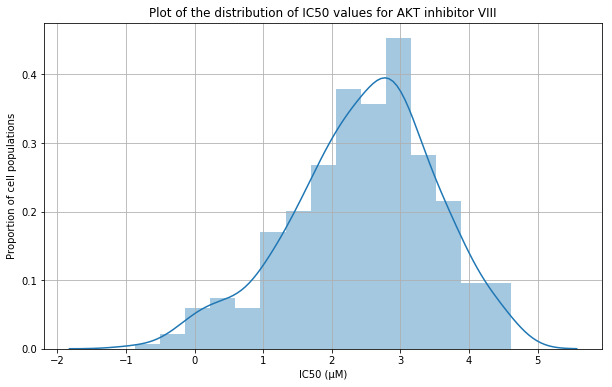

In [18]:
fig = plt.figure(figsize = (10,6))
sns.distplot(drug_matrix[[drug_name]])
plt.title("Plot of the distribution of IC50 values for "+ drug_name)
plt.xlabel("IC50 (µM)")
plt.ylabel("Proportion of cell populations")
plt.grid(True);

In [19]:
drug_matrix.head()

,PIK3R1_mut,ARFGAP3_mut,ASH1L_mut,RB1_mut,CTNND1_mut,MAP3K4_mut,ATRX_mut,DDX3X_mut,ASXL1_mut,IDH1_mut,...,GATA3_mut,SETDB1_mut,TJP1_mut,CHD6_mut,CIC_mut,ZC3H11A_mut,TBX3_mut,FOXP1_mut,SCAI_mut,AKT inhibitor VIII
22RV1_PROSTATE,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.179495
A204_SOFT_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.715336
A253_SALIVARY_GLAND,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.300805
A673_BONE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.505491
ALLSIL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272181


In [20]:
drug_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 369 entries, 22RV1_PROSTATE to SKNBE2_AUTONOMIC_GANGLIA
Columns: 255 entries, PIK3R1_mut to AKT inhibitor VIII
dtypes: float64(255)
memory usage: 738.0+ KB


Checking the types of features :

In [22]:
features = list(drug_matrix.columns)

mut = []
del_amp = []

for name in features :
    
    if 'mut' in name :
        
        mut.append(name)
    
    else :
        
        del_amp.append(name)
        

In [23]:
print('The number of features labeled as mutations are: ', len(mut))
print('The number of features labeled as deletions or amplifications are: ', len(del_amp))

The number of features labeled as mutations are:  254
The number of features labeled as deletions or amplifications are:  1


### Modeling

In [158]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn import svm

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error


In [94]:
X = drug_matrix.drop(drug_name, axis = 1).copy()
y = drug_matrix.iloc[:, -1].copy()

In [123]:
np.random.seed(0)

#Scaling the features -- useful for most classifier except RF and co        
feature_names = list(X) #stores the name of features
sc = StandardScaler()  #defines the scaler
X = pd.DataFrame(sc.fit_transform(X)) #scales the data
X.columns = feature_names 

#### Linear Regression: Baseline

Cross - Validation Results

In [122]:
np.random.seed(0)

lr = LinearRegression()
lr_scores = cross_val_score(lr, X, y, cv=5)  # fit + predict + eval.
print('Linear Regression Average Score', str(round(lr_scores.mean()*100,3)),'%', '+/-', str(round(100*np.std(lr_scores),3)))


Linear Regression Average Score -1237.465 % +/- 483.291


Train - Test Split Results

In [99]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)

print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (258, 254)
y_train shape:  (258,)
X_test shape:  (111, 254)
y_test shape:  (111,)


In [100]:
# Instantiate a linear regressor: lr
lr = LinearRegression()

# Fit the regressor to the data
lr.fit(X_train, y_train)

# Predict on the test data
y_pred = lr.predict(X_test)

# Model evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = lr.score(X_test, y_test)
exp_v = explained_variance_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('The MSE is: ', round(mse, 5))
print('The MAE is: ', round(mae, 5))

print('The R^2 score is: ', round(r2, 5))
print('The explained variance score is:', round(exp_v, 5))


The MSE is:  79.20901
The MAE is:  7.05765
The R^2 score is:  -89.87792
The explained variance score is: -89.66799


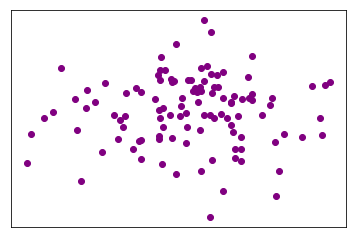

In [101]:
# Plot outputs
plt.scatter(y_test, y_pred,  color='purple');
plt.xticks(())
plt.yticks(())

plt.show()

#### Least Absolute Shrinkage & Selection Operator (LASSO)

Cross - Validation Results

In [106]:
np.random.seed(0)

lasso = Lasso(alpha = 100)
lasso_scores = cross_val_score(lasso,X, y, cv=5)  # fit + predict + eval.

print('Lasso Regression Average Score', str(round(lasso_scores.mean()*100,3)),'%', '+/-', str(round(100*np.std(lasso_scores),3)))

Lasso Regression Average Score -1.256 % +/- 1.177


Train - Test Split Results

In [149]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a lasso regressor: lasso
lasso = Lasso(alpha=0.010, normalize=True)

# Fit the regressor to the data
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)


# Model evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = lasso.score(X_test, y_test)
exp_v = explained_variance_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('The MSE is: ', round(mse, 5))
print('The MAE is: ', round(mae, 5))

print('The R^2 score is: ', round(r2, 5))
print('The explained variance score is:', round(exp_v, 5))


The MSE is:  0.88926
The MAE is:  0.74814
The R^2 score is:  -0.02026
The explained variance score is: 0.00088


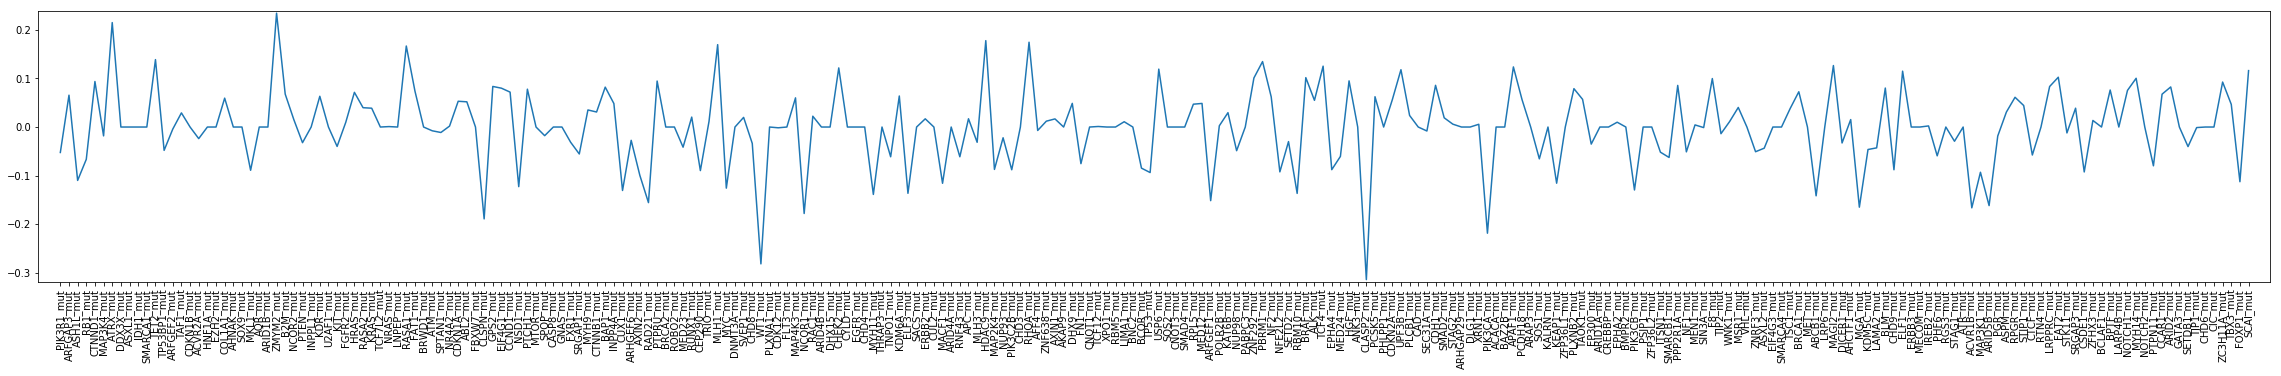

In [117]:
# Plot the coefficients
fig= plt.figure(figsize=(40,5))


plt.plot(range(len(X_train.columns)), lasso.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.01)
plt.show()

#### Ridge Regression

Cross - Validation Results

In [147]:
np.random.seed(0)

ridge = Ridge(alpha = 150, normalize = True)
ridge_scores = cross_val_score(ridge,X, y, cv= 5)  # fit + predict + eval.
print('Ridge Regression Average Score', str(round(ridge_scores.mean()*100,3)),'%', '+/-', str(round(100*np.std(ridge_scores),3)))

Ridge Regression Average Score -1.148 % +/- 1.19


Train - Test Split Results

In [146]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a lasso regressor: lasso
ridge = Ridge(alpha=100, normalize=True)

# Fit the regressor to the data
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)


# Model evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = ridge.score(X_test, y_test)
exp_v = explained_variance_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('The MSE is: ', round(mse, 5))
print('The MAE is: ', round(mae, 5))

print('The R^2 score is: ', round(r2, 5))
print('The explained variance score is:', round(exp_v, 5))


The MSE is:  0.88579
The MAE is:  0.74477
The R^2 score is:  -0.01629
The explained variance score is: 0.00443


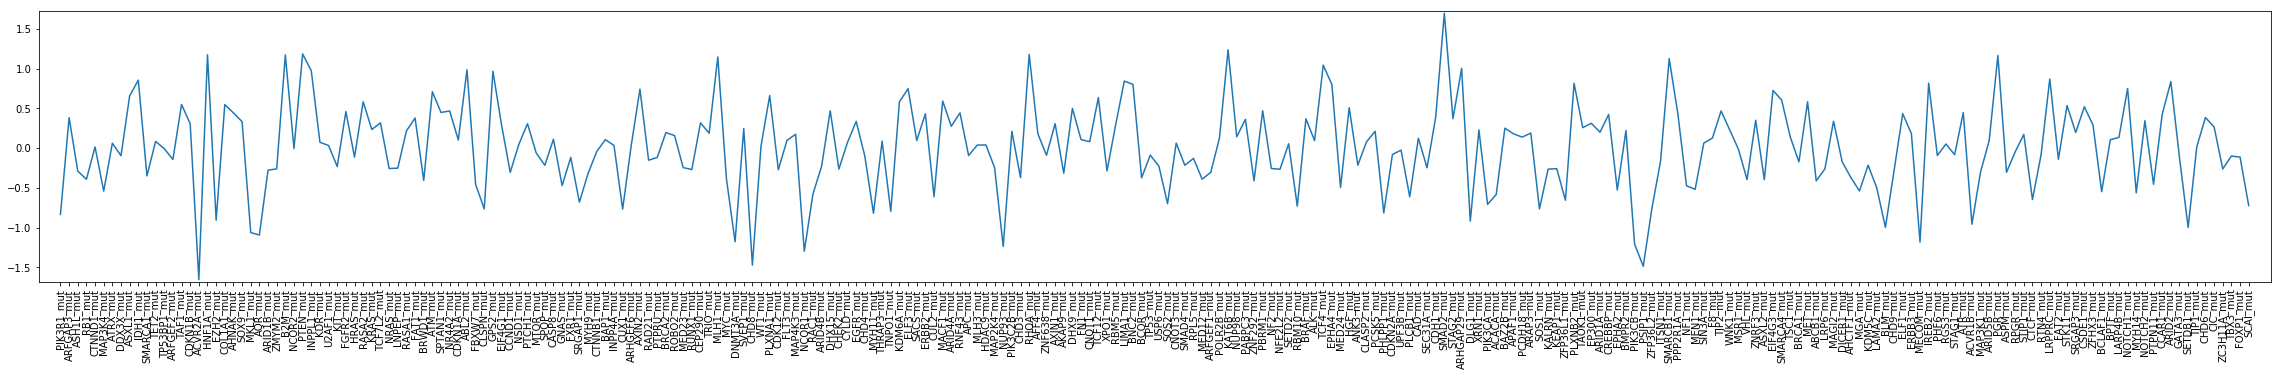

In [118]:
# Plot the coefficients
fig= plt.figure(figsize=(40,5))


plt.plot(range(len(X_train.columns)), ridge.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=90)
plt.margins(0.01)
plt.show()

#### Elastic Net

Cross - Validation Results

In [151]:
np.random.seed(0)

en = ElasticNet(alpha = 5, l1_ratio = 0.01, normalize = True)
en_scores = cross_val_score(en,X, y, cv=5)  # fit + predict + eval.
print('Elastic Net Average Score', str(round(en_scores.mean()*100,3)),'%', '+/-', str(round(100*np.std(en_scores),3)))

Elastic Net Average Score -1.256 % +/- 1.177


Train - Test Split Results

In [154]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

# Instantiate a lasso regressor: lasso
en = ElasticNet(alpha = 5, l1_ratio = 0.01, normalize = True)

# Fit the regressor to the data
en.fit(X_train, y_train)
y_pred = en.predict(X_test)


# Model evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = en.score(X_test, y_test)
exp_v = explained_variance_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('The MSE is: ', round(mse, 5))
print('The MAE is: ', round(mae, 5))

print('The R^2 score is: ', round(r2, 5))
print('The explained variance score is:', round(exp_v, 5))


The MSE is:  0.88916
The MAE is:  0.74538
The R^2 score is:  -0.02015
The explained variance score is: 0.0
